In [27]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from lib.extractor import ImgExtractor
from lib.compare import compare_similarity
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
from tensorflow.keras import layers, Model

# 1: Build dataset for train data & val data

### 1.1: Read data & change to numpy arr

In [3]:
img_path = "Dataset/Synthetic_Effusion/12/12.png" 

In [5]:
raw_img = Image.open(img_path)
if np.array(raw_img).shape[-1] == 4:
    raw_img = raw_img.convert('RGB')
resized_img = raw_img.resize((224, 224))
raw_arr = np.array(resized_img)

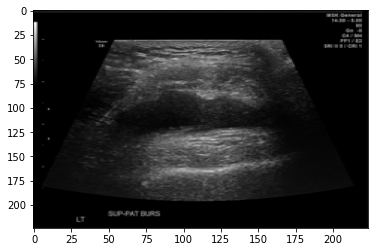

In [6]:
plt.imshow(raw_arr, aspect="auto")
plt.show()

In [7]:
img_arr = np.expand_dims(raw_arr, axis=0)

In [8]:
raw_arr.shape

(224, 224, 3)

In [9]:
img_arr.shape

(1, 224, 224, 3)

### 1.2: Data augmentation

(参考: https://www.tensorflow.org/tutorials/images/data_augmentation)
- Future step:
  - 1: Load all image
  - 2: Rotate some of them
  - 3: Train model

In [28]:
def rotate_img(img_arr):
    data_augmentation = tf.keras.Sequential([
#         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # heart location matters
        layers.experimental.preprocessing.RandomRotation(0.2),
    ])
    augmented_img_arr = data_augmentation(img_arr)

    return augmented_img_arr

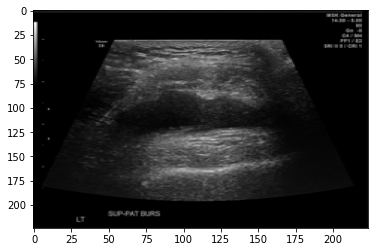

In [29]:
plt.imshow(raw_arr, aspect="auto")
plt.show()

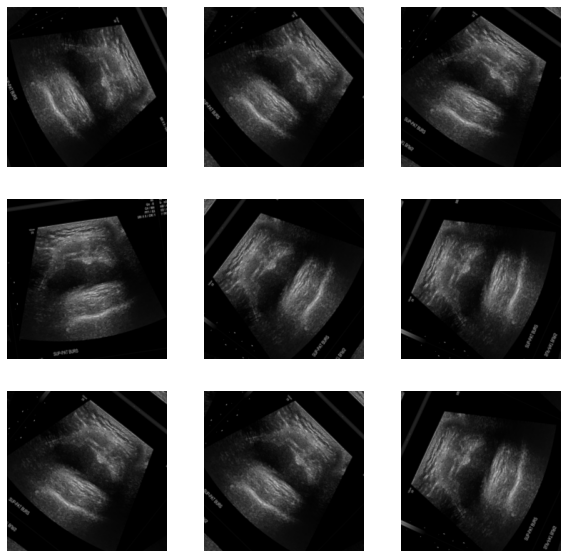

In [30]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_img_arr = rotate_img(img_arr)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_img_arr[0])
    plt.axis("off")

## 2 Test module: Img Feature Extractor + Similarity Function

In [10]:
extractor = ImgExtractor(model="VGG16")
img_fea = extractor.extract_features(img_path)

In [14]:
img_path1 = "Dataset/Synthetic_Effusion/2/2.jpg"
img_path2 = "Dataset/Synthetic_Effusion/12/12.png"

In [15]:
img_fea1 = extractor.extract_features(img_path1)
img_fea2 = extractor.extract_features(img_path2)

In [16]:
simiScore = compare_similarity(img_fea1, img_fea2)

In [18]:
simiScore

array([[0.87695813]], dtype=float32)

# 7 Define classification model

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Model
# (224 * 224 * 3) -> (5 * 5 * 20) > 500 > 50 > 20 > 2
model = tf.keras.applications.VGG16()
num_classes = 2

# define layer
flat = layers.Flatten(name="qiaFlat") # 5 * 5 * 20 -> 500 
dense1 = layers.Dense(50, activation='relu', name="qiaDense") # 500 > 50
dropout1 = layers.Dropout(0.5, name="qiaDropout") # 50 -> 50% 的数随机变0
batch1 = layers.BatchNormalization() # no need to do
output = layers.Dense(num_classes, activation = 'softmax') # 50 -> 2 (0, 1)

#number of classes in your dataset e.g. 20

# define model input process
x = flat(model.output) # 5 * 5 * 20 -> 200
x = dense1(x) # 
x = dropout1(x)
x = batch1(x)
predictions = output(x)

#create graph of your new model
new_model = Model(model.input, predictions)

#compile the model
new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

new_model.summary()

#train your model on data
# head_model.fit(x, y, batch_size = batch_size, verbose = 1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
new_model.predict(img_arr)

# Next step